In [1]:
import ee
import geemap
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
# import geopandas as gpd

In [2]:
ee.Initialize()

In [3]:
#shp path
tp_src = 'sgcplot.shp'
tp_crop = 'croplabel.shp'
tp_ncrop = 'noncroplabel.shp'

#TODO training data explaination 

#ee object
sgc_ee = geemap.shp_to_ee(tp_src)
crop_ee = geemap.shp_to_ee(tp_crop)
nncrop_ee = geemap.shp_to_ee(tp_ncrop)
#feature collection
crop_fc = sgc_ee.merge(crop_ee)
fc = crop_fc.merge(nncrop_ee)
#define bounding box
bbox = ee.Geometry.bounds(fc)
aoi = bbox

In [4]:
#Sentinel 2 Image collection, cloudmask and mosaic

def imgcoll(sdate,edate):

    # sdate= '2020-05-01'
    # edate= '2020-08-31'

    def cloud_prob():
        innerJoined = ee.Join.inner().apply(**{
            'primary':ee.ImageCollection("COPERNICUS/S2_SR")\
                .filterBounds(aoi)\
                    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10)),
            'secondary': ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY")\
                .filterBounds(aoi),       
            'condition':ee.Filter.equals(**{
                'leftField':'system:index',
                'rightField':'system:index',
            })
        })
        def mergeBands(joinresult):
            return ee.Image(joinresult.get('primary'))\
                .addBands(joinresult.get('secondary'))
        newCollection = innerJoined.map(mergeBands)
        return ee.ImageCollection(newCollection)

    collection = cloud_prob().filterDate(sdate, edate)

    def maskcloud(_image):
        cloudProbabilityThreshold =10
        cloudMask = _image.select('probability').lt(cloudProbabilityThreshold)
        return _image.updateMask(cloudMask)

    image = collection.map(maskcloud).median().divide(10000)
    return image

In [5]:
_image_pltss = imgcoll('2020-05-01', '2020-08-31')

In [8]:
def imgpsh(image):

    #Resolution merge of 20m bands to 10m -TODO explain the process
    panchro = (image.select('B2').add(image.select('B3'))\
                .add(image.select('B4')).add(image.select('B8')))\
                .divide(4).rename('pan')
    image = image.addBands(panchro)

    bands = ['B5','B6','B7','B8A','B9','B11','B12']

    def sharpen(image):
        kernel = ee.Kernel.square(**{
            'radius': 20,
            'units':'meters'
        })
        toSharpen = image.select(bands)
        pan = image.select('pan')
        meanPan = pan.reduceNeighborhood(**{
            'reducer' : ee.Reducer.mean(),
            'kernel' : kernel
        })
        offset = pan.subtract(meanPan)
        return toSharpen.add(offset)
    sharpened = sharpen(image)    
    return sharpened

In [9]:
psh_image_pltss = imgpsh(_image_pltss)

In [ ]:
#continue to make everything a single function

In [7]:
#image c0llection relevant bands (all in 10m)
bands10m = image.select(['B2','B3','B4','B8'])
imagef = bands10m.addBands(sharpened)
image_feature = imagef.clip(aoi)

In [8]:
#vegetation indices - TODO comment on the use of each VI
def Veg_Index(image_name):
    #NDVI
    ndvi = image_name.expression(
        '(NIR+RED)/(NIR - RED)', {
            'NIR': image_name.select('B8'),
            'RED': image_name.select('B4')
        }).rename('NDVI')
    #EVI
    evi = image_name.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',{
        'NIR': image_name.select('B8'),
        'RED': image_name.select('B4'),
        'BLUE': image_name.select('B2')
    }).rename('EVI')
    #GCVI Green Chlorophyll Vegetation Index - TODO read about GCVI use cases
    gcvi = image_name.expression(
    '(NIR / GREEN) - 1',{
        'NIR':image_name.select('B8'),
        'GREEN':image_name.select('B3')
    }).rename('GCVI')
    #RDGCVI
    rgcvi = image_name.expression(
    '(NIR / REDE1) - 1',{
        'NIR':image_name.select('B8'),
        'REDE1':image_name.select('B5')
    }).rename('RDGCVI')
    #DVI
    dvi = image_name.expression(
        'NIR/RED',{
            'NIR':image_name.select('B8'),
            'RED':image_name.select('B4')
        }).rename('DVI')
    return image_name.addBands(ndvi).addBands(evi).addBands(gcvi).addBands(rgcvi).addBands(dvi)
#image composite of all spectral indices and bands
image_featureWithVI = Veg_Index(image_feature)

In [7]:
#sentinel 1
sdate= '2020-05-01'
edate= '2020-08-31'
VVcollection = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
    .filterBounds(aoi)\
    .filterDate(sdate,edate)\
    .select(['VV'])


In [9]:
visparam = {'min': 0.0, 'max': 0.9, 'pallete':['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301']}
Map.addLayer(aoi, {}, 'aoi' )
# Map.addLayer(image_featureWithVI, {'bands': ['B9', 'B11', 'B12'], 'min': 0.0, 'max': 0.3}, 'Original')
# Map.addLayer(image_featureWithVI, {'bands': ['B9', 'B11', 'B12'], 'min': 0.0, 'max': 0.3}, 'Sharpen 1')
# Map.addLayer(image_featureWithVI, {'bands': ['B8', 'B4', 'B3'], 'min': 0.0, 'max': 0.3}, 'False Colour COmposite')
# Map.addLayer(image_featureWithVI, {'bands': ['B4', 'B3', 'B2'], 'min': 0.0, 'max': 0.3}, 'True Colour COmposite')
Map.addLayer(image_featureWithVI, visparam, 'NDVI')
Map.addLayer(image_featureWithVI, visparam, 'GCVI')

In [9]:
#exprot to assest
task = ee.batch.Export.image.toAsset(**{'image':image_featureWithVI,
'description': 'Compositeband',
'assetId':'users/aadebowaledaniel/BCcomposite2', 
'scale': 10, 
'region':aoi.getInfo()['coordinates'],
'maxPixels': 1e13,
})
task.start()
#Monitor the task
while task.status()['state'] in ['READY', 'RUNNING']:
  print(task.status())
  time.sleep(5)
else:
  print(task.status())

TAUD6GWQZQAVJCBU'}
{'state': 'RUNNING', 'description': 'Compositeband', 'creation_timestamp_ms': 1622562102583, 'update_timestamp_ms': 1622562177453, 'start_timestamp_ms': 1622562146775, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'TATEMVD4TAUD6GWQZQAVJCBU', 'name': 'projects/earthengine-legacy/operations/TATEMVD4TAUD6GWQZQAVJCBU'}
{'state': 'RUNNING', 'description': 'Compositeband', 'creation_timestamp_ms': 1622562102583, 'update_timestamp_ms': 1622562177453, 'start_timestamp_ms': 1622562146775, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'TATEMVD4TAUD6GWQZQAVJCBU', 'name': 'projects/earthengine-legacy/operations/TATEMVD4TAUD6GWQZQAVJCBU'}
{'state': 'RUNNING', 'description': 'Compositeband', 'creation_timestamp_ms': 1622562102583, 'update_timestamp_ms': 1622562177453, 'start_timestamp_ms': 1622562146775, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'TATEMVD4TAUD6GWQZQAVJCBU', 'name': 'projects/earthengine-legacy/operations/TATEMVD4TAUD6GWQZQAVJCBU'}
{'state': 'RUNNING', 

In [16]:
Map = geemap.Map(center=(0.9613,34.6536),zoom=8)
Map

Map(center=[0.9613, 34.6536], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

In [17]:
Map.addLayer(Imageclassified,{'min':0, 'max':1, 'pallete': ['662A00', 'D8D8D8']}, 'Classification')


In [9]:
#import composite from asset
#predimage = ee.Image('users/aadebowaledaniel/BCcomposite')
predimage= image_featureWithVI

In [10]:
predbands = predimage.bandNames()
#predbands = ['B2','B5','B6','B7','B8A','B9','B12', 'NDVI','EVI','GCVI','DVI','RDGCVI']

In [11]:
#continue from here
trainingSample  = predimage.sampleRegions(
    collection = fc,
    properties=['label'],
    scale = 10, 
    geometries = True
)
# trainingSample.size().getInfo()

rantraning = trainingSample.randomColumn('random')
split = 0.7
trainsample = rantraning.filter(ee.Filter.lt('random', split))
testsample = rantraning.filter(ee.Filter.gte('random', split))

#train random forest classifier
classifier = ee.Classifier.smileRandomForest(100).train(trainsample, 'label', predbands)


#confusion matrix train Accurracy
trainAccuracy = classifier.confusionMatrix()
print('Resubstitution error matrix: ', trainAccuracy.getInfo())
print('Training overall accuracy: ', trainAccuracy.accuracy().getInfo())

#classify features
testclassifier = testsample.classify(classifier)
#cconfusion matrix representing expected accuracy
testAccuracy = testclassifier.errorMatrix('label', 'classification')
print('confusion Matrix', testAccuracy.getInfo())
print('Valdation overall accuracy:', testAccuracy.accuracy().getInfo())

#classify image
Imageclassified = predimage.classify(classifier)
# altImageclassified = predimage.classify(classifier)

Resubstitution error matrix:  [[500, 12], [0, 3730]]
Training overall accuracy:  0.9969317913618126
confusion Matrix [[156, 54], [5, 1627]]
Valdation overall accuracy: 0.9679695982627579


In [9]:
# cropmask = Imageclassified.eq(1)
# # vis = {'pallete':['#18d848']}
# Map.addLayer(cropmask,{'color':'green'}, 'Crop')

cropmask = Imageclassified.eq(1)

cropmaskdd = cropmask.updateMask(cropmask)

cropmask_vec = cropmaskdd.reduceToVectors(
    geometryType= 'polygon',
    reducer= ee.Reducer.countEvery(),
    scale= 10,
    maxPixels= 1e13,
    geometry= aoi
)
Map.addLayer(cropmask_vec, {'color':'green'}, 'Crop Mask')

In [12]:
vrimp = classifier.explain().getInfo().get('importance') #TODO chart in python

In [13]:
bands = []
vim = []
for x, y in vrimp.items():
    bands.append(x)
    vim.append(y)

cmcm = list(zip(bands,vim))
df = pd.DataFrame(cmcm, columns = ['features', 'mda'])

In [14]:
df['importance'] = (df['mda']/df['mda'].sum())
df = df.sort_values('importance', ascending=True)

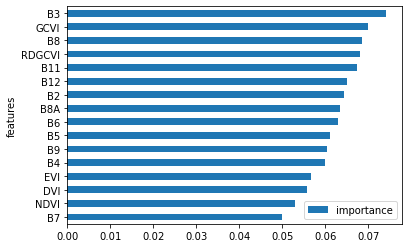

In [15]:
df.plot.barh('features', 'importance')
plt.show()

In [ ]:
# Map.addLayer(image, {'bands': ['B4', 'B3', 'B2'], 'min': 0.0, 'max': 0.3, 'gamma': 2}, 'True colour composite')


In [11]:
cropmask = Imageclassified.eq(1)
# vis = {'pallete':['#18d848']}
Map.addLayer(cropmask,{'color':'green'}, 'Vegetation')

cropmask = Imageclassified.eq(2)

cropmaskdd = cropmask.updateMask(cropmask)

cropmask_vec = cropmaskdd.reduceToVectors(
    geometryType= 'polygon',
    reducer= ee.Reducer.countEvery(),
    scale= 10,
    maxPixels= 1e13,
    geometry= aoi
)
Map.addLayer(cropmask_vec, {'color':'green'}, 'Crop Mask')

In [15]:
# #convert to Vector
# cropmask = Imageclassified.eq(1)

# vector_cropmask = cropmask.updateMask(cropmask).reduceToVectors(
#     reducer=ee.Reducer.countEvery(),
#     geometry= aoi,
#     scale=10,
#     maxPixels=1e13)
# def sim(nna):
#     return nna.simplify(maxError = 100)
# vector_cropmask = vector_cropmask.map(sim)
# cropmaskVec = cropmask.reduceToVectors({
#     # 'geometryType': 'polygon',
#   'reducer': ee.Reducer.countEvery(),
#   'scale': 10,
#   'geometry':aoi,
# })

# vector_img = Imageclassified.unmask(0).reduceToVectors(
#         geometry = aoi,
#         scale = 10,
#         maxPixels = 1e13,
#         bestEffort =True
#     )
# taskvec = ee.batch.Export.table.toAsset(collection=vector_cropmask,
# description= 'Vegetation mask', assetId= 'users/aadebowaledaniel/vegetationmask')
# taskvec.start()
# #Monitor the task
# while taskvec.status()['state'] in ['READY', 'RUNNING']:
#   print(taskvec.status())
#   time.sleep(5)
# else:
#   print(taskvec.status())